In [38]:
from __future__ import print_function
import os
import sys
import math
import pickle
import pdb
import argparse
import random
from tqdm import tqdm
from shutil import copy
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from scipy.linalg import qr 
import igraph as ig
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from util import *
from modelsRIGHT import *
from igraph import *
import networkx as nx
from collections import Counter
import importlib
from sklearn.decomposition import PCA
from dotmap import DotMap
import pandas as pd
import json
from scipy.stats import wasserstein_distance
import csv
from pathlib import Path
import re
import visualize_util
from visualize_util import *

p = os.path.join("vertex_5_7dim_latent_KL0.01_DVAE_NOBATCHNORM_ROW_hs256_batchsize64","final_structures6_4")
vis_path = os.path.join(p, "evaluation")
csv_file_path = "summary.csv"
if( not os.path.exists(vis_path)):
    os.makedirs(vis_path)
argsFile = os.path.join(p,"cmd_input.txt")
with open(argsFile) as f:
    argsJSON = json.load(f)
args = DotMap(argsJSON)


In [14]:
# df = pd.read_csv("vertex_4_2dim_latent_batchnorm2\\final_structures6\\train_loss.txt", sep= " ")
# df2 = pd.read_csv("vertex_4_4dim_latent\\final_structures6\\train_loss.txt", sep= " ")
# df3 = pd.read_csv("train_lossBIG.txt", sep= " ")
# df4 = pd.read_csv("vertex_4_2dimLatent_new\\final_structures6\\train_loss.txt", sep= " ")
df5 = pd.read_csv(os.path.join(p,"train_loss.txt"), sep= " ")

ix=df5.iloc[:,[0,2]].sum(1).idxmin()
# print(ix)
# print(df5.iloc[[300]])


<Figure size 640x480 with 0 Axes>

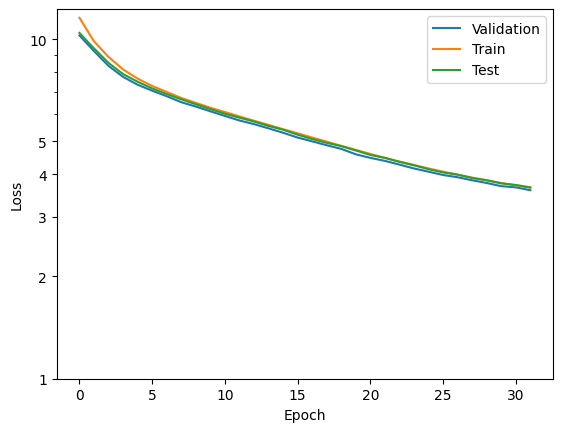

In [15]:
plt.figure(dpi = 100)
fig1, ax1 = plt.subplots()
ax1.plot(df5.iloc[:,3], label='Validation')
ax1.plot(df5.iloc[:,0], label='Train')
ax1.plot(df5.iloc[:,4], label='Test')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yscale('log')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')


ax1.legend()
ax1.set_yticks([10,5,4,3,2,1])
ax1.set_yticklabels([10,5,4,3,2,1])
ax1.get_yaxis().get_major_formatter().labelOnlyBase = False
# plt.plot(df3.iloc[:2949,4], label='Total')

In [16]:


args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
np.random.seed(args.seed)
random.seed(args.seed)
print(device)


cuda:0


In [49]:
graph_args = DotMap()
graph_args.max_n = args.nvt
graph_args.num_vertex_type = args.max_n
graph_args.START_TYPE = 0
graph_args.END_TYPE = 1
model = eval(args.model)(
        graph_args.max_n, 
        graph_args.num_vertex_type, 
        graph_args.START_TYPE, 
        graph_args.END_TYPE, 
        hs=args.hs, 
        nz=args.nz, 
        bidirectional=args.bidirectional        )
model.device = device
model = model.to(device)
print(model.get_device())
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
print(graph_args)

cuda:0
DotMap(max_n=7, num_vertex_type=7, START_TYPE=0, END_TYPE=1)


In [18]:
all_data = []
all_data2 = []
train_data = []
test_data = []
graph_path = os.path.join("..", "graph_data", "vertex5")
for ix,filename in enumerate(tqdm(os.listdir(graph_path))):
    path = os.path.join(graph_path, filename)
    with open(path, 'rb') as pickle_file:
        # Load file
        graph = pickle.load(pickle_file)
        edge_list = graph.get_edgelist()
        # Create new graph
        graph2 = ig.Graph(directed=True)
        graph2.add_vertices(args.max_n)
        # Copy vertices to new graph
        for vs_i in range(len(graph.vs)):
            graph2.vs[vs_i+1]['type'] =  graph.vs[vs_i]['_nx_name']+2
        # Copy edges to new graph
        for edge_pair in edge_list:
            p1 = edge_pair[0]
            p2 = edge_pair[1]
            graph2.add_edge(p1+1,p2+1)
        # Set vertex attributes
        graph2.vs[0]['type'] = graph_args.START_TYPE
        graph2.vs[args.max_n-1]['type'] = graph_args.END_TYPE
        # graph2.add_edge(0,1)
        # graph2.add_edge(4,5)

        for vs_i,vs in enumerate(graph2.vs[1:-1]):
            if(len(vs.in_edges()) == 0):
                graph2.add_edge(0, vs_i+1)
            if(len(vs.out_edges()) == 0):
                graph2.add_edge(vs_i+1, len(graph2.vs)-1)
        all_data.append(graph2)
        all_data2.append(graph2)

print(all_data[0].vs["type"])
# print(all_data[1].vs["type"])
print(len(all_data))



100%|██████████| 29281/29281 [00:06<00:00, 4295.92it/s]

[0, 4, 6, 5, 2, 3, 1]
29281


In [19]:
g = all_data[0]
nodeTypes = sorted(g.vs["type"])
n2 =  "".join([str(nodeType) for nodeType in nodeTypes + [0]] + [str(neighbour)  for nodeType in nodeTypes for neighbour in sorted([g.vs[nodeIndex]["type"] for nodeIndex in g.neighbors(g.vs.find(type = nodeType), 'in')])+[0]])
print(n2)

012345600230450460006040


In [26]:

model_dir = os.path.join(p, "model")
print(model_dir)
files = [os.path.join(model_dir, file) for file in os.listdir(model_dir)]
latest_checkpoint = max(files, key= os.path.getctime)
print(latest_checkpoint)
latest_checkpoint_filename = Path(latest_checkpoint).name
print(latest_checkpoint_filename)
last_epoch = re.findall(r'\d+', latest_checkpoint_filename)
print(last_epoch[0])

# q = 563
# latest_checkpoint = os.path.join(model_dir,"model_checkpoint"+str(q)+".pth")
# print(latest_checkpoint)
load_module_state(model,latest_checkpoint)



vertex_5_7dim_latent_KL0.01_DVAE_NOBATCHNORM_ROW_hs256_batchsize64/final_structures6_4/model
vertex_5_7dim_latent_KL0.01_DVAE_NOBATCHNORM_ROW_hs256_batchsize64/final_structures6_4/model/model_checkpoint33.pth
model_checkpoint33.pth
33


In [43]:
importlib.reload(visualize_util)

latents = []
extended = []
min_mu = 2
max_mu = -1
min_g = None
max_g = None
percect_recon = 0
for data in tqdm(all_data):
    mu, logvar = model.encode(data)
    z = model.reparameterize(mu,logvar)
    g_recon = model.decode(z)

    h1 = visualize_util.DAG_hash(data)
    for g_r in g_recon:
        h2 = visualize_util.DAG_hash(g_r)
        if h1 == h2:
            percect_recon+=1
            break
    mu = mu.cpu().detach().numpy()

    latents.append(mu)
    null_edges = data.neighbors(0, 'out')
    # print(data.vcount())
    end_edges = data.neighbors(args.max_n-1, 'in')
    max_degree = np.max(data.vs.degree())
    in_degree = np.max(data.vs.indegree())
    out_degree = np.max(data.vs.outdegree())
    zero_pred =  len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "in") == [0]])    
    zero_succ = len([ix for ix in range(data.vcount()) if  data.neighbors(ix, "out") == [args.max_n-1]])
    
    minus_edges = len(null_edges) + len(end_edges)
    mu  = np.append(mu, data.ecount()- minus_edges)
    mu  = np.append(mu, max_degree)
    mu  = np.append(mu, in_degree)
    mu  = np.append(mu, out_degree)
    mu  = np.append(mu, zero_pred)
    mu  = np.append(mu, zero_succ)




    
    extended.append(mu)

latents = np.array(latents)
extended = np.array(extended)
print(latents.shape)
# print(latents)

100%|██████████| 29281/29281 [12:18<00:00, 39.64it/s]


(29281, 1, 7)


In [44]:
print("Z_mean: " + str(latents.mean(0)))
print("Z_std: " + str(latents.std(0)))
print("Z norm: " + str(np.linalg.norm(latents)))

Z_mean: [[-0.67143714 -0.4205377  -0.12585029  0.36677212 -0.767512   -0.14954323
  -0.30372974]]
Z_std: [[0.9246343 1.1445056 1.1773217 1.0126654 0.9604857 0.8802108 1.0989307]]
Z norm: 512.2976


<class 'numpy.ndarray'>


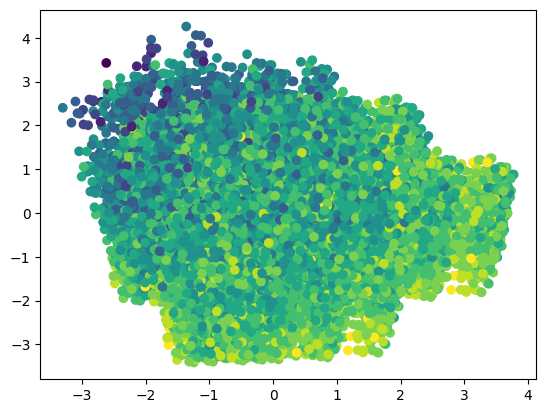

In [45]:
a = latents.reshape((len(all_data),args.nz))
pca = PCA(n_components=2)
components = pca.fit_transform(a)
print(type(components))

fig, ax = plt.subplots(facecolor=(1, 1, 1))
scatter = ax.scatter(components[:,0], components[:,1], c=extended[:,args.nz])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left",bbox_to_anchor=(1.04, 1))
ax.add_artist(legend1)
fig_name = os.path.join(vis_path, "all_data_encoded")
fig.savefig(fig_name,bbox_inches='tight')
plt.show()



In [50]:
print(graph_args)

DotMap(max_n=7, num_vertex_type=7, START_TYPE=0, END_TYPE=1)


In [51]:


def prior_validity():
    Z_train = latents
    Zs_valid = []
    Zs_invalid = []
    Zs_plus_decode = []
    Wrapped_G = []
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    # print(z_mean)
    # print(z_std)
    z_mean, z_std = torch.FloatTensor(z_mean).to(device), torch.FloatTensor(z_std).to(device)
    n_latent_points = 5000
    decode_times = 10
    n_valid = 0
    print('Prior validity experiment begins...')
    G = []
    G_valid = []
    G_train = [g for g in train_data]
    pbar = tqdm(range(n_latent_points))
    cnt = 0
    G_valid = []
    G_invalid = []
    n_valid = 0
    for i in pbar:
        cnt += 1
        if cnt == args.infer_batch_size or i == n_latent_points - 1:
            z = torch.randn(cnt, model.nz).to(model.get_device())
        # print(z)
            z = z * z_std + z_mean  # move to train's latent range
        # print(z)
            
            # print(z.cpu().detach().numpy())

            for j in range(decode_times):
                g_batch = model.decode(z)
                for ix,g in enumerate(g_batch):
                    if is_valid_BN(g, graph_args.START_TYPE, graph_args.END_TYPE,args.nvt):
                        n_valid +=1
                        G_valid.append(g)
                        Wrapped_G.append(GraphWrapper(g))
                        Zs_valid.append(z.cpu().detach().numpy()[ix])
                    else:
                        G_invalid.append(g)
                        Zs_invalid.append(z.cpu().detach().numpy()[ix])


            cnt = 0
    return G_valid, G_invalid, Zs_valid, Zs_invalid, Wrapped_G


valid, invalid, Zs_valid, Zs_invalid, Wrapped_G = prior_validity()
print(len(valid))
print(len(invalid))


Prior validity experiment begins...


100%|██████████| 5000/5000 [02:44<00:00, 30.39it/s]

347
49653


In [13]:
def interpolation_exp3(model,data):
    print('Interpolation experiments around a great circle')
    interpolate_number = 36
    model.eval()
    g_ix = random.randint(0,len(data))
    g0 =  data[g_ix]
    z0, _ = model.encode(g0)
    norm0 = torch.norm(z0)
    z1 = torch.ones_like(z0)
    # there are infinite possible directions that are orthogonal to z0,
    # we just randomly pick one from a finite set
    dim_to_change = random.randint(0, z0.shape[1]-1)  # this to get different great circles
    print(dim_to_change)
    z1[0, dim_to_change] = -(z0[0, :].sum() - z0[0, dim_to_change]) / z0[0, dim_to_change]
    z1 = z1 / torch.norm(z1) * norm0
    print('z0: ', z0, 'z1: ', z1, 'dot product: ', (z0 * z1).sum().item())
    print('norm of z0: {}, norm of z1: {}'.format(norm0, torch.norm(z1)))
    print('distance between z0 and z1: {}'.format(torch.norm(z0-z1)))
    omega = torch.acos(torch.dot(z0.flatten(), z1.flatten()))
    print('angle between z0 and z1: {}'.format(omega))
    Z = []  # to store all the interpolation points
    for j in range(0, interpolate_number + 1):
        theta = 2*math.pi / interpolate_number * j
        zj = z0 * np.cos(theta) + z1 * np.sin(theta)
        Z.append(zj)
    Z = torch.cat(Z, 0)
    # decode many times and select the most common one
    G, _ = decode_from_latent_space(latent_points=Z,model= model,decode_attempts=1, return_igraph=True, data_type=args.data_type) 
    for j in range(0, interpolate_number + 1):
        if G[j] is not None:
            g_x = G[j].to_networkx()
            pos = nx.circular_layout(g_x)
            nx.draw_networkx(g_x, pos=pos)
# interpolation_exp3(model,all_data)



In [14]:
def visualize_recon(epoch):
    model.eval()
    # draw some reconstructed train/test graphs to visualize recon quality
    for i, g in enumerate(test_data[:1]):
        if args.model.startswith('SVAE'):
            g = g.to(device)
            g = model._collate_fn(g)
            g_recon = model.encode_decode(g)[0]
            g = model.construct_igraph(g[:, :, :model.nvt], g[:, :, model.nvt:], False)[0]
        elif args.model.startswith('DVAE'):
            g_recon = model.encode_decode(g)[0]
        name0 = 'graph_epoch{}_id{}_original'.format(epoch, i)

        save0 =  os.path.join(args.fig_dir, name0)
        g_x = g.to_networkx()
        nx.draw_networkx(g_x)
        plt.show()
        plt.savefig(save0)
        plt.close()
        name1 = 'graph_epoch{}_id{}_recon'.format(epoch, i)
        save1 = os.path.join(args.fig_dir, name1)
        g_x_recon = g_recon.to_networkx()
        nx.draw_networkx(g_x_recon)
        plt.show()
        plt.savefig(save1)
        plt.close()

In [15]:
# dim = 6
# z_std = np.random.rand(1,dim)
# z_mean = np.random.rand(1,dim)
# print(z_std)
# print(z_mean)
def interpolate1_randomPoints(n_split):
    z1 = torch.randn(1,model.nz).to(model.get_device())
    z2 = torch.randn(1,model.nz).to(model.get_device())
    Z_train = latents
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    z_mean, z_std = torch.FloatTensor(z_mean).to(model.get_device()), torch.FloatTensor(z_std).to(model.get_device())
    z1 = z1 * z_std + z_mean
    z2 = z2 * z_std + z_mean
    z_diff = (z1-z2)/n_split
    points = []
    for i in range(n_split+1):
        offset = z_diff*i
        c_z = offset+z2
        print(c_z.size())
        points.append(c_z.cpu().detach().numpy())
        # g = model.decode(c_z)
        g, _ = decode_from_latent_space(c_z,model,500,'variable',True, 'BN')
        g_x = g[0].to_networkx()
        pos = nx.circular_layout(g_x)
        nx.draw_networkx(g_x, pos=pos)
        plt.show()
    points = np.array(points)
    print(np.shape(points))
    points = points.reshape((n_split+1,args.nz))
    pca = PCA(n_components=2)
    components = pca.fit_transform(points)
    plt.scatter(components[:,0], components[:,1])
    plt.scatter(points[:,0], points[:,1])
    for point in points:
        print(point)
    for component in components:
        print(component)
    return components


# comp2 = interpolate1(5)


In [16]:
# def interpolate2_randomGraphs(n_split):
#     g_s = random.sample(all_data,2)
#     z1 = model.encode(g_s[0])
#     z2 = model.encode(g_s[1])
#     Z_train = latents
#     z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
#     z_mean, z_std = torch.FloatTensor(z_mean).to(model.get_device()), torch.FloatTensor(z_std).to(model.get_device())
#     z1 = z1 * z_std + z_mean
#     z2 = z2 * z_std + z_mean
#     z_diff = (z1-z2)/n_split
#     points = []
#     for i in range(n_split+1):
#         offset = z_diff*i
#         c_z = offset+z2
#         print(c_z.size())
#         points.append(c_z.cpu().detach().numpy())
#         # g = model.decode(c_z)
#         g, _ = decode_from_latent_space(c_z,model,500,'variable',True, 'BN')
#         g_x = g[0].to_networkx()
#         nx.draw_networkx(g_x)
#         plt.show()
#     points = np.array(points)
#     print(np.shape(points))
#     points = points.reshape((n_split+1,args.nz))
#     pca = PCA(n_components=2)
#     components = pca.fit_transform(points)
#     plt.scatter(components[:,0], components[:,1])
#     plt.scatter(points[:,0], points[:,1])
#     for point in points:
#         print(point)
#     for component in components:
#         print(component)
#     return components

In [17]:
if(len(invalid) > 0):
    print(invalid[0])
    print(invalid[0].vs["type"])

IGRAPH D--T 7 8 --
+ attr: type (v)
+ edges:
0->1 0->2 0->3 1->4 4->5 2->6 3->6 5->6
[0, 5, 2, 6, 5, 3, 1]


In [18]:
print(len(all_data))
print(len(valid))
valid2 = valid.copy()
for g in all_data2:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

for g in valid2:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

29281
44817


In [19]:
def is_same_DAG2(g0, g1):
    # note that it does not check isomorphism
    if g0.vcount() != g1.vcount():
        return False
    if set(g0.vs["type"]) != set(g1.vs["type"]):
        return False
    if g0.ecount() != 0 or g1.ecount() == 0:
        for vi in range(g0.vcount()):
            g0_index_of_type = g0.vs.find(type=vi+2)
            g1_index_of_type = g1.vs.find(type=vi+2)
            # g0_vs = g0.vs[g0_index_of_type]
            # g1_vs = g1.vs[g1_index_of_type]

            # if g0.vs[vi]['type'] != g1.vs[vi]['type']:
            #     return False
            g0_neighbours = set([g0.vs[vs_i]["type"] for vs_i in g0.neighbors(g0_index_of_type, 'in')])
            g1_neighbours = set([g1.vs[vs_i]["type"] for vs_i in g1.neighbors(g1_index_of_type, 'in')])
            if g0_neighbours != g1_neighbours:
                return False
    return True

In [11]:
g = all_data[0]
print(g)

print(g.vs["type"])
g.vs["type"].sort()
print(g)


IGRAPH D--T 7 9 --
+ attr: type (v)
+ edges:
1->2 1->4 1->5 2->3 2->5 3->4 0->1 4->6 5->6
[0, 4, 6, 5, 2, 3, 1]
IGRAPH D--T 7 9 --
+ attr: type (v)
+ edges:
1->2 1->4 1->5 2->3 2->5 3->4 0->1 4->6 5->6


In [20]:
# NEM FOG LEFUTNI
# from wrapper import GraphWrapper
import wrapper
importlib.reload(wrapper)
# decode_ix = []
# for v_ix,v in enumerate(tqdm(valid2)) :
#     for d_ix,d in enumerate(all_data2):
#         if is_same_DAG2(v,d):
#             decode_ix.append(d_ix)
#             break
        
# print(len(decode_ix))
# print()

w_g = wrapper.GraphWrapper(all_data[1]) 
adj = w_g.graph.get_adjacency()
print(adj)
print(w_g.graph.vs["type"])
print("---------")
print(w_g.__hash__())
print(type(adj))
# print(w_g.graph.vs["type"])
# a = [1,2,3]
# n_c = []
# c_c = {}
# for i_l,l in enumerate(adj[:]):
#     if len(c_c) == 0:
#             c_c[w_g.graph.vs["type"][i_l]] = i_l
#     if i_l != adj.shape[0]-1 and l[i_l+1] == 0:
#         c_c[w_g.graph.vs["type"][i_l+1]] = i_l+1
#     else:
#         n_c.append(c_c)
#         c_c = {}

# e_c = []
# for n in n_c:
#     x = dict(sorted(n.items()))
#     e_c.append(x)

# res = []
# print(".............")


# res = [adj[s_e] for e in e_c for s_e in e.values()]
# res_labels = [s_e for e in e_c for s_e in e.keys()]

# print(res)
# print(res_labels)








print("-----")
# print(n_c)
# print(e_c)
# # print(i_c)
# print(w_g.graph.vs["type"])
# print(all_data[0].get_adjacency())



[[0, 0, 0, 0, 1]
 [0, 0, 1, 0, 1]
 [0, 0, 0, 1, 1]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]]
[3, 4, 2, 6, 5]
---------
Flat list str: 0000000000010001110000100
Flat list int: 9092
Flat list str2: 9092
Hash list: 909234256
hash list str: 909234256
909234256
<class 'igraph.datatypes.Matrix'>
-----


/tmp/ipykernel_13117/2846072655.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [21]:
print(adj)
n = w_g.graph
# print(n)
arr = [a for a in adj]
# print(arr)
n = np.array(arr)




n_c = []
c_c = {}
adj = w_g.graph.get_adjacency()
for i_l,l in enumerate(adj[:]):
    if len(c_c) == 0:
            c_c[w_g.graph.vs["type"][i_l]] = i_l
    if i_l != adj.shape[0]-1 and l[i_l+1] == 0:
        c_c[w_g.graph.vs["type"][i_l+1]] = i_l+1
    else:
        n_c.append(c_c)
        c_c = {}

e_c = []
for n in n_c:
    x = dict(sorted(n.items()))
    e_c.append(x)

res = []

print(e_c)


res = [adj[s_e] for e in e_c for s_e in e.values()]
r_n = np.array(res)
print(r_n)
print("------")
f_r = [r_n[:,s_e] for e in e_c for s_e in e.values()]
flat_list = [item for sublist in f_r for item in sublist]
print(flat_list)
res_labels = [s_e for e in e_c for s_e in e.keys()]
print(w_g.__hash__())


[[0, 0, 0, 0, 1]
 [0, 0, 1, 0, 1]
 [0, 0, 0, 1, 1]
 [0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0]]
[{3: 0, 4: 1}, {2: 2}, {5: 4, 6: 3}]
[[0 0 0 0 1]
 [0 0 1 0 1]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]]
------
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0]
Flat list str: 0000000000010001110000100
Flat list int: 9092
Flat list str2: 9092
Hash list: 909234256
hash list str: 909234256
909234256


In [52]:
import collections
importlib.reload(wrapper)
hashes = []
for w_g in Wrapped_G:
    to_append = w_g.__hash__()
    hashes.append(to_append)
    print(to_append)

counter = collections.Counter(hashes)
c_values = list(counter.values())
# print(c_values)
print(len(c_values))
print(np.max(c_values))
plt.bar([i for i in range(len(c_values))], c_values)
plt.show()


NameError: name 'wrapper' is not defined

In [35]:
print(type(hashes[0]))
# print(hashes)
print(len(hashes))
print(hashes[0])
# TODO
# Hash all_data, create {hash, index} map, map hashes, create array from indexes, np hist
all_data_hashes = {}
for ix,a in enumerate(all_data2):
    g_a = GraphWrapper(a)
    g_a_hash = g_a.__hash__()
    all_data_hashes[g_a_hash] = ix

<class 'int'>
44817
54977436524
Flat list str: 0000010000010001010011000
Flat list int: 533144
Flat list str2: 533144
Hash list: 53314446523
hash list str: 53314446523
Flat list str: 0000000000010001110000100
Flat list int: 9092
Flat list str2: 9092
Hash list: 909234256
hash list str: 909234256
Flat list str: 0000010000110000110011010
Flat list int: 549274
Flat list str2: 549274
Hash list: 54927425463
hash list str: 54927425463
Flat list str: 0000000000100001010001110
Flat list int: 17038
Flat list str2: 17038
Hash list: 1703856234
hash list str: 1703856234
Flat list str: 0000010000110000010001110
Flat list int: 549006
Flat list str2: 549006
Hash list: 54900643652
hash list str: 54900643652
Flat list str: 0000010000110000110000010
Flat list int: 549250
Flat list str2: 549250
Hash list: 54925052634
hash list str: 54925052634
Flat list str: 0000010000010001010011010
Flat list int: 533146
Flat list str2: 533146
Hash list: 53314645236
hash list str: 53314645236
Flat list str: 0000000000110

44817


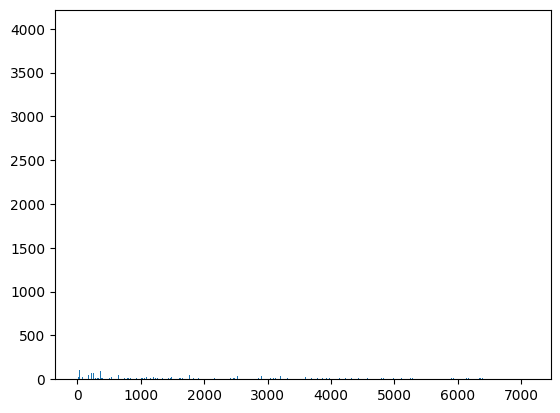

In [47]:
mapped_hashes = [ all_data_hashes[h] if h in all_data_hashes else len(all_data2) for h in hashes]
print(len(mapped_hashes))
counter = collections.Counter(mapped_hashes)
c_values = list(counter.values())
plt.bar([i for i in range(len(c_values))], c_values)
plt.show()

In [37]:
# print(all_data_hashes)

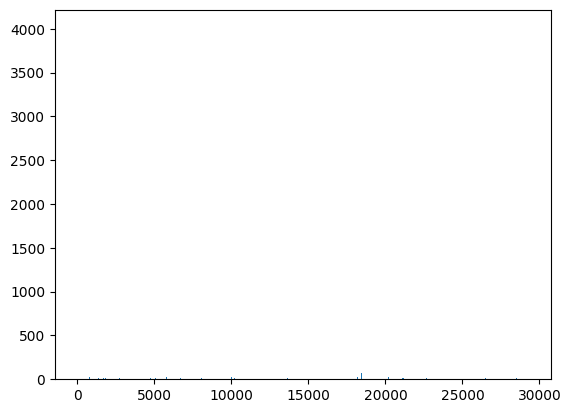

In [41]:
hist1 = np.histogram(mapped_hashes,bins = len(all_data2))
plt.bar([i for i in range(len(hist1[0]))], hist1[0])
fig_name = os.path.join(vis_path, "frequencies")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))
plt.show()


In [31]:
print(hist1[0])
print(len(hist1[0]))


[615 402 210 ...   0   0   3]
29281


In [ ]:
print(hist1)


(array([44537,    57,     2,   102,     6,     2,    74,     1,     8,
          28]), array([2.34560000e+04, 1.26484543e+11, 2.52969063e+11, 3.79453583e+11,
       5.05938103e+11, 6.32422623e+11, 7.58907143e+11, 8.85391663e+11,
       1.01187618e+12, 1.13836070e+12, 1.26484522e+12]))


In [46]:
uni = np.random.randint(0,542,len(all_data))
uni2 = np.random.randint(0,542,len(all_data))
m_mean =np.mean(hist1[0][:-2])
m_median =np.median(hist1[0][:-2])
m_std = np.std(hist1[0][:-2])
m_max = np.max(hist1[0][:-2])
m_max_ix = np.argmax(hist1[0])
m_wasser = wasserstein_distance(uni,hist1[0][:-2])
print("Mean: " + str(m_mean))
print("Median: " + str(m_median))
print("Std: " + str(m_std))
print("Max: " + str(m_max))
print("Max index: " + str(m_max_ix))
print("Distance from uniform distribution: " + str(m_wasser))
print("Uni to Uni: " + str(wasserstein_distance(uni,uni2)))
dir_name = Path(p).parent.name

# csv_file_path = "s2.csv"
with open(csv_file_path, 'a+', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter = ';' )
    writer.writerow([dir_name,args.model, last_epoch[0], args.nz, args.hs,  args.beta,m_mean, m_median, m_std,m_max, m_wasser, len(valid)])



Mean: 1.3934902148297414
Median: 0.0
Std: 4.612575154823718
Max: 130
Max index: 29280
Distance from uniform distribution: 269.455114682544
Uni to Uni: 0.8632218844984819


29281


<BarContainer object of 543 artists>

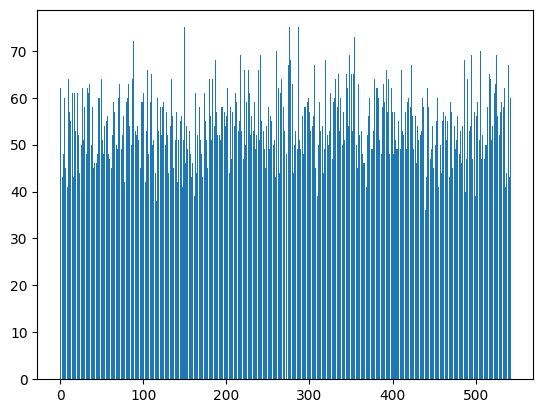

In [ ]:
# print(uni)
print(len(uni))
hist2 = np.histogram(uni, bins=543)
plt.bar([i for i in range(len(hist2[0]))], hist2[0])

In [ ]:
from scipy import stats
print(stats.mode(decode_ix))

NameError: name 'decode_ix' is not defined

In [ ]:
test_g = all_data[0]
print(test_g)
print(test_g.get_adjacency())
flat_list = [item for sublist in test_g.get_adjacency()[1:] for item in sublist[:-1]]
print(flat_list)
print(len(flat_list))
print(test_g.vs["type"])
hash_list = flat_list + test_g.vs["type"]
print(hash_list)
hash_list_str = ''.join(map(str,hash_list))
print(int(hash_list_str))

In [ ]:
Zs_valid = np.array(Zs_valid)
print(Zs_valid.shape)

pca = PCA(n_components=2)
sampled_components = pca.fit_transform(Zs_valid)
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

plt.scatter(sampled_components[:,0], sampled_components[:,1], c=decode_ix)
fig_name = os.path.join(vis_path, "sampled")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

# plt.scatter(Zs_valid[:,0], Zs_valid[:,1], c=decode_ix)

In [ ]:
most_common = counter.most_common(1)[0][0]
print(most_common)

to_print = [ix for ix in range(len(decode_ix)) if decode_ix[ix] == most_common]
print(len(to_print))
Zs_valid_filtered = [Zs_valid[x] for x in range(len(Zs_valid)) if x in to_print]
print(len(Zs_valid_filtered))
Zs_valid_filtered = np.array(Zs_valid_filtered)
plt.scatter(Zs_valid_filtered[:,0], Zs_valid_filtered[:,1])

In [ ]:
Zs_invalid = np.array(Zs_invalid)
print(Zs_invalid.shape)
plt.scatter(Zs_invalid[:,0], Zs_invalid[:,1])